In [186]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Churn Prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [187]:
%pip install scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [188]:
!SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True pip install ../..

Processing /Users/andrew.chan/lifetime_value
  Preparing metadata (setup.py) ... done
  Created wheel for lifetime-value: filename=lifetime_value-0.1-py3-none-any.whl size=11220 sha256=d81a9038051e4c4ea5e199d6489a63519543c789533e31ed5f5a0226fe67d6f9
  Stored in directory: /private/var/folders/_x/lk156_010zvdrbc289hkw0180000gp/T/pip-ephem-wheel-cache-3skfm17m/wheels/f0/57/13/3cbd2c64aad6b4e360557b0e10580dc2fe41b0c49ab9a9c64f
Successfully built lifetime-value
  Attempting uninstall: lifetime-value
    Found existing installation: lifetime-value 0.1
    Uninstalling lifetime-value-0.1:
      Successfully uninstalled lifetime-value-0.1


In [189]:
import os

import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
import lifetime_value as ltv

In [190]:
tfd = tfp.distributions
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [ ]:
COMPANY = '10490004'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/result'  # @param { isTemplate: true, type: 'string'}

In [192]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [193]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [194]:
# %%bash
# if [ -e /tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv ]
# then
#   echo "File already exists, no need to download."
# else
#   rm -rf /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   mkdir -p /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   cd /tmp/lifetime-value/acquire-valued-shoppers-challenge
#   kaggle competitions download -c acquire-valued-shoppers-challenge
#   echo "Unzip file. This may take 10 min."
#   gunzip transactions.csv.gz
# fi

### Load transaction csv

In [195]:
def load_transaction_data(company):
  all_data_filename = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv'
  one_company_data_filename = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions_company_{}.csv'
      .format(COMPANY))
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=={}".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [196]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [197]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [198]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

350it [01:44,  3.34it/s]


In [199]:
customer_level_data.head

<bound method NDFrame.head of                 id  calibration_value chain dept category  brand  \
0            86246              11.58   205   36     3630  23359   
1            86252               0.99   205   21     2105  14357   
2         12262064               1.72    95   21     2105  14357   
3         12277270               4.49    95   36     3601   3809   
4         12332190               1.49    95   36     3611   4599   
...            ...                ...   ...  ...      ...    ...   
249280  4824696849               1.00    46   36     3601   3809   
249281  4829517835               6.98    46   36     3601   3809   
249282  4837642552               4.99    46   36     3611   4599   
249283  4847628950              16.65   166   36     3618  23359   
249284  4847787712               3.67    46   36     3601   3809   

       productmeasure  holdout_value  log_calibration_value       label  
0                  OZ     358.260010               2.449280  358.260010  
1    

We observe a mixture of zero and lognormal distribution of holdout value.

<Axes: >

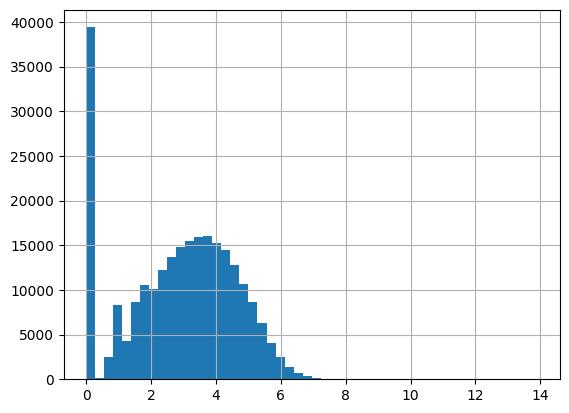

In [200]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

In [201]:
customer_level_data.head().T

,0,1,2,3,4
id,86246,86252,12262064,12277270,12332190
calibration_value,11.58,0.99,1.72,4.49,1.49
chain,205,205,95,95,95
dept,36,21,21,36,36
category,3630,2105,2105,3601,3611
brand,23359,14357,14357,3809,4599
productmeasure,OZ,OZ,OZ,OZ,OZ
holdout_value,358.26001,336.649994,32.310001,186.75,53.610001
log_calibration_value,2.44928,-0.01005,0.542324,1.501853,0.398776
label,358.26001,336.649994,32.310001,186.75,53.610001


## Data

### Make train/eval

In [202]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values

  x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=123)

  return x_train, x_eval, y_train, y_eval

In [203]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  df_train, df_eval = model_selection.train_test_split(
      df, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval

## Model

In [204]:
def linear_model(output_units):
  return tf.keras.experimental.LinearModel(output_units)

In [205]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Train

In [206]:
if LOSS == 'bce':
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [207]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  model = linear_model(output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [208]:
if LOSS == 'bce':
  y_train = (y_train > 0).astype('float32')
  y_eval = (y_eval > 0).astype('float32')

In [209]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [210]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [211]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/400
195/195 - 1s - loss: 5.9930 - val_loss: 4.6460 - lr: 0.0010 - 637ms/epoch - 3ms/step
Epoch 2/400
195/195 - 0s - loss: 4.6167 - val_loss: 4.6248 - lr: 0.0010 - 233ms/epoch - 1ms/step
Epoch 3/400
195/195 - 0s - loss: 4.6108 - val_loss: 4.6220 - lr: 0.0010 - 226ms/epoch - 1ms/step
Epoch 4/400
195/195 - 0s - loss: 4.6083 - val_loss: 4.6191 - lr: 0.0010 - 228ms/epoch - 1ms/step
Epoch 5/400
195/195 - 0s - loss: 4.6059 - val_loss: 4.6170 - lr: 0.0010 - 226ms/epoch - 1ms/step
Epoch 6/400
195/195 - 0s - loss: 4.6046 - val_loss: 4.6160 - lr: 0.0010 - 238ms/epoch - 1ms/step
Epoch 7/400
195/195 - 0s - loss: 4.6038 - val_loss: 4.6162 - lr: 0.0010 - 237ms/epoch - 1ms/step
Epoch 8/400
195/195 - 0s - loss: 4.6037 - val_loss: 4.6152 - lr: 0.0010 - 229ms/epoch - 1ms/step
Epoch 9/400
195/195 - 0s - loss: 4.6027 - val_loss: 4.6148 - lr: 0.0010 - 223ms/epoch - 1ms/step
Epoch 10/400
195/195 - 0s - loss: 4.6018 - val_loss: 4.6147 - lr: 0.0010 - 229ms/epoch - 1ms/step
Epoch 11/400
195/195 - 0s - l

<Axes: >

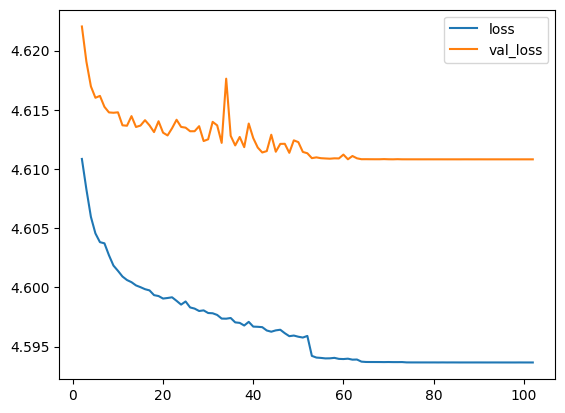

In [212]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [213]:
logits = model.predict(x=x_eval, batch_size=1024)
y_pred = K.sigmoid(logits[..., :1]).numpy().flatten()

49/49 [==============================] - 0s 491us/step


In [214]:
y_true = (y_eval > 0).astype('float32')

In [215]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [216]:
classification = classification_report(y_true, y_pred)
classification

,AUC,PR_AUC,precision,recall,f1
0,0.663456,0.908508,0.846,0.997601,0.915568


### All metrics together

In [217]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [218]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

,company,model,loss,label_mean,pred_mean,AUC,PR_AUC,precision,recall,f1
0,104900040,dnn,ziln,0.844395,0.842242,0.663456,0.908508,0.846,0.997601,0.915568


## Save

In [219]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [220]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [221]:
output_file = os.path.join(output_path,
                           '{}_classification_{}.csv'.format(MODEL, LOSS))

In [222]:
df_metrics.to_csv(output_file, index=False)